# Werkzeug zur Analyse und Bearbeitung von Audiofrequenzen (+ Halleffekt)

Mit diesem Tool:
1. können Sie eine WAV-Datei hochladen und eine Fourier-Analyse durchführen
2. können Sie das Frequenz-Amplituden-Diagramm anzeigen
3. können Sie die Frequenz auswählen und die Amplitude mit dem Textfeld ändern
4. Sie können das Frequenzspektrum der Sinuswellen, aus denen die aktuelle WAV-Datei besteht, verschieben.
5. Im Zeitbereich können Sie einen Halleffekt zwischen den von Ihnen ausgewählten Sekunden anwenden.
6. Sie können die Änderungen speichern und wiederherstellen.
7. Sie können das Ergebnis als WAV-Datei exportieren.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.fft import fft, ifft, fftfreq
import json
import ipywidgets as widgets
from IPython.display import display, clear_output
import os
from collections import OrderedDict
import scipy.signal as signal

## 1. das Laden von WAV-Dateien und die Fourier-Analyse

In [ ]:
def upload_wav():
    from google.colab import files
    uploaded = files.upload()
    for filename in uploaded.keys():
        if filename.lower().endswith('.wav'):
            return filename
    return None

In [ ]:
def analyze_audio(filename):
    # Ses dosyasını yükle
    sample_rate, data = wavfile.read(filename)

    # Mono'ya çevir (stereo ise)
    if len(data.shape) > 1:
        data = data.mean(axis=1)

    global original_audio, fs
    fs, original_audio = wavfile.read(filename)

    # Normalize et (float32 olarak)
    original_audio = original_audio.astype(np.float32)

    # Mono'ya çevir (stereo ise)
    if original_audio.ndim > 1:
        original_audio = original_audio.mean(axis=1) # Convert to mono if stereo

    original_audio /= np.max(np.abs(original_audio))

    # FFT hesapla
    n = len(data)
    yf = fft(data)
    xf = fftfreq(n, 1 / sample_rate)

    # Sadece pozitif frekansları al
    half_n = n // 2
    xf = xf[:half_n]
    yf = 2/n * np.abs(yf[:half_n])

    # Sonuçları JSON olarak kaydet
    fourier_data = {str(freq): float(amp) for freq, amp in zip(xf, yf)}
    scheme = {"frequency": "amplitude"}

    combined = OrderedDict()
    combined.update(scheme)      # önce "frequency": "amplitude"
    combined.update(fourier_data)

    with open('fourier-analysis.json', 'w') as f:
        json.dump(combined, f)

    return xf, yf, sample_rate, data

In [ ]:
# Kullanıcıdan WAV dosyası yüklemesini iste
print("Lütfen analiz edilecek WAV dosyasını yükleyin:")
filename = upload_wav()

if filename:
    print(f"'{filename}' dosyası analiz ediliyor...")
    freqs, amps, sample_rate, original_data = analyze_audio(filename)
    print("Fourier analizi tamamlandı ve 'fourier-analysis.json' olarak kaydedildi.")
else:
    print("WAV dosyası yüklenmedi. Lütfen sonra tekrar deneyin.")

Lütfen analiz edilecek WAV dosyasını yükleyin:


Saving guitar.wav to guitar (2).wav
'guitar (2).wav' dosyası analiz ediliyor...


<ipython-input-3-6740a80ea345>:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, data = wavfile.read(filename)
<ipython-input-3-6740a80ea345>:10: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, original_audio = wavfile.read(filename)


Fourier analizi tamamlandı ve 'fourier-analysis.json' olarak kaydedildi.


## 2. die Anzeige der Frequenzchart

In [ ]:
# Grafik oluşturma fonksiyonu
def plot_frequencies(freqs, amps, selected_freq=None):
    plt.figure(figsize=(15, 6))

    # Tüm frekansları çiz
    plt.plot(freqs, amps, color='blue', alpha=0.7, label='Frekans Spektrumu')

    # Seçilen frekansı vurgula (varsa)
    if selected_freq is not None:
        idx = np.abs(freqs - selected_freq).argmin()
        plt.scatter(freqs[idx], amps[idx], color='red', s=100, label=f'Seçilen: {selected_freq:.2f} Hz')

    plt.title('Frekans - Amplitüd Grafiği')
    plt.xlabel('Frekans (Hz)')
    plt.ylabel('Amplitüd')
    plt.xscale('log')
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.legend()
    plt.show()

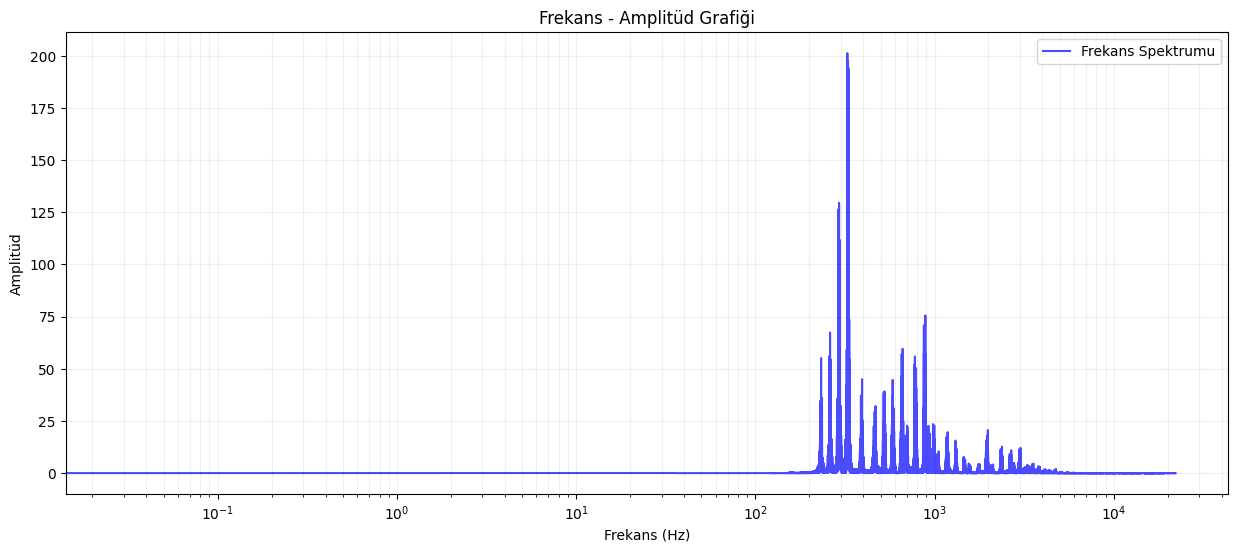

In [ ]:
# Grafiği göster
if 'freqs' in locals() and 'amps' in locals():
    plot_frequencies(freqs, amps)

## 3. die Schnittstelle zur Frequenzbearbeitung mit Textbox

In [ ]:
# Değişiklikleri takip etmek için global değişkenler
modified_amps = amps.copy() if 'amps' in locals() else None
current_selected_freq = None
current_impact_range = 1000
parabolic_impact = False

In [ ]:
def select_frequency(change):
    global current_selected_freq

    try:
        selected_freq = float(freq_text.value)
        if selected_freq < 0:
            print("Frekans değeri pozitif olmalıdır!")
            return

        current_selected_freq = selected_freq
        idx = np.abs(freqs - selected_freq).argmin()

        clear_output(wait=True)
        plot_frequencies(freqs, modified_amps, current_selected_freq)
        display(ui_controls)

        print(f"Seçilen Frekans: {current_selected_freq:.2f} Hz, Mevcut Amplitüd: {modified_amps[idx]:.2f}")

    except ValueError:
        print("Lütfen geçerli bir frekans değeri girin!")
    except Exception as e:
        print(f"Hata oluştu: {str(e)}")

In [ ]:
def apply_changes(change):
    global modified_amps, current_selected_freq, current_impact_range, parabolic_impact

    if current_selected_freq is None:
        print("Lütfen önce bir frekans seçin!")
        return

    try:
        # Kullanıcı girdilerini al
        amplitude_change = float(amplitude_text.value)
        current_impact_range = float(impact_range_text.value)
        parabolic_impact = parabolic_checkbox.value

        # Seçilen frekansın indeksini bul
        target_idx = np.abs(freqs - current_selected_freq).argmin()

        # Amplitüd değişikliğini uygula
        if parabolic_impact and current_impact_range > 0:
            # Parabolik etki uygula
            start_freq = max(0, current_selected_freq - current_impact_range)
            end_freq = current_selected_freq + current_impact_range

            start_idx = np.abs(freqs - start_freq).argmin()
            end_idx = np.abs(freqs - end_freq).argmin()

            for i in range(start_idx, end_idx + 1):
                # Parabolik ağırlık hesapla (tepe noktası seçilen frekansta)
                distance = np.abs(freqs[i] - current_selected_freq)
                if distance <= current_impact_range:
                    # Normalize edilmiş mesafe (0-1 arası)
                    normalized_dist = distance / current_impact_range
                    # Parabolik ağırlık (1 - x^2)
                    weight = 1 - (normalized_dist ** 2)
                    modified_amps[i] += amplitude_change * weight
        else:
            # Sadece seçilen frekansı değiştir
            modified_amps[target_idx] += amplitude_change

        # Grafiği güncelle
        clear_output(wait=True)
        plot_frequencies(freqs, modified_amps, current_selected_freq)
        display(ui_controls)

        print(f"Değişiklikler uygulandı: {current_selected_freq:.2f} Hz frekansına {amplitude_change:.2f} amplitüd değişikliği")
        if parabolic_impact:
            print(f"Parabolik etki: ±{current_impact_range:.2f} Hz aralığına uygulandı")

    except ValueError:
        print("Lütfen geçerli sayısal değerler girin!")
    except Exception as e:
        print(f"Hata oluştu: {str(e)}")

In [ ]:
def zero_amplitude_umwelt(change):
    global modified_amps, current_selected_freq, current_impact_range, parabolic_impact

    if current_selected_freq is None:
        print("Lütfen önce bir frekans seçin!")
        return

    try:
        current_impact_range = float(impact_range_text.value)
        parabolic_impact = parabolic_checkbox.value

        # Seçilen frekansın indeksini bul
        target_idx = np.abs(freqs - current_selected_freq).argmin()

        if parabolic_impact and current_impact_range > 0:
            # Parabolik etki uygulanacak aralığı belirle
            start_freq = max(0, current_selected_freq - current_impact_range)
            end_freq = current_selected_freq + current_impact_range

            start_idx = np.abs(freqs - start_freq).argmin()
            end_idx = np.abs(freqs - end_freq).argmin()

            for i in range(start_idx, end_idx + 1):
                distance = np.abs(freqs[i] - current_selected_freq)
                if distance <= current_impact_range:
                    modified_amps[i] = 0.0  # Sıfırlama
        else:
            modified_amps[target_idx] = 0.0  # Sadece seçilen frekansı sıfırla

        # Grafiği güncelle
        clear_output(wait=True)
        plot_frequencies(freqs, modified_amps, current_selected_freq)
        display(ui_controls)

        print(f"{current_selected_freq:.2f} Hz frekansı sıfırlandı.")
        if parabolic_impact:
            print(f"Parabolik sıfırlama: ±{current_impact_range:.2f} Hz aralığına uygulandı")

    except ValueError:
        print("Lütfen geçerli sayısal değerler girin!")
    except Exception as e:
        print(f"Hata oluştu: {str(e)}")

In [ ]:
def zero_amplitude(change):
    global modified_amps, current_selected_freq, current_impact_range, parabolic_impact

    if current_selected_freq is None:
        print("Lütfen önce bir frekans seçin!")
        return

    try:
        current_impact_range = float(impact_range_text.value)
        parabolic_impact = parabolic_checkbox.value

        # Seçilen frekansın indeksini bul
        target_idx = np.abs(freqs - current_selected_freq).argmin()

        if parabolic_impact and current_impact_range > 0:
            # Parabolik etki uygulanacak aralığı belirle
            start_freq = max(0, current_selected_freq - current_impact_range)
            end_freq = current_selected_freq + current_impact_range

            start_idx = np.abs(freqs - start_freq).argmin()
            end_idx = np.abs(freqs - end_freq).argmin()

            for i in range(start_idx, end_idx + 1):
                distance = np.abs(freqs[i] - current_selected_freq)
                if distance <= current_impact_range:
                    normalized_dist = distance / current_impact_range  # 0–1 arası
                    weight = 1 - (normalized_dist ** 2)  # parabol: 1 tepe, 0 kenarlar
                    modified_amps[i] *= (1 - weight)  # %100 azalma → 0, %0 azalma → kalır
        else:
            modified_amps[target_idx] = 0.0  # Sadece seçilen frekansı sıfırla

        # Grafiği güncelle
        clear_output(wait=True)
        plot_frequencies(freqs, modified_amps, current_selected_freq)
        display(ui_controls)

        print(f"{current_selected_freq:.2f} Hz frekansı parabolik olarak zayıflatıldı.")
        if parabolic_impact:
            print(f"Parabolik etki: ±{current_impact_range:.2f} Hz aralığında uygulandı")

    except ValueError:
        print("Lütfen geçerli sayısal değerler girin!")
    except Exception as e:
        print(f"Hata oluştu: {str(e)}")


In [ ]:
def save_changes(b):
    changes = {
        'modified_amps': modified_amps.tolist(),
        'selected_freq': current_selected_freq,
        'impact_range': current_impact_range,
        'parabolic_impact': parabolic_impact
    }

    with open('eq_settings.json', 'w') as f:
        json.dump(changes, f)

    print("Ayarlar 'eq_settings.json' olarak kaydedildi.")

In [ ]:
def load_changes(b):
    global modified_amps, current_selected_freq, current_impact_range, parabolic_impact

    try:
        with open('eq_settings.json', 'r') as f:
            changes = json.load(f)

        modified_amps = np.array(changes['modified_amps'])
        current_selected_freq = changes['selected_freq']
        current_impact_range = changes['impact_range']
        parabolic_impact = changes['parabolic_impact']

        # UI elemanlarını güncelle
        freq_text.value = str(current_selected_freq) if current_selected_freq else ''
        amplitude_text.value = '0'
        impact_range_text.value = str(current_impact_range)
        parabolic_checkbox.value = parabolic_impact

        clear_output(wait=True)
        plot_frequencies(freqs, modified_amps, current_selected_freq)
        display(ui_controls)

        print("Ayarlar başarıyla yüklendi!")

    except FileNotFoundError:
        print("Kaydedilmiş ayar dosyası bulunamadı!")
    except Exception as e:
        print(f"Hata oluştu: {str(e)}")

In [ ]:
def export_audio(b):
    global modified_amps, freqs, sample_rate, original_data

    try:
        # Orijinal verinin uzunluğu
        n = len(original_data)

        # FFT hesapla
        yf = fft(original_data)

        # Modified_amps boyutunu kontrol et ve gerekirse ayarla
        expected_length = n // 2
        if len(modified_amps) != expected_length:
            print(f"Uyarı: modified_amps boyutu ({len(modified_amps)}) beklenen ({expected_length}) ile uyuşmuyor. Ayarlanıyor...")
            if len(modified_amps) > expected_length:
                modified_amps = modified_amps[:expected_length]
            else:
                modified_amps = np.pad(modified_amps, (0, expected_length - len(modified_amps)), 'constant')

        # Scale faktörünü hesapla (sıfır bölme hatasını önle)
        original_magnitudes = 2/n * np.abs(yf[:expected_length])
        scale_factor = np.divide(modified_amps, original_magnitudes,
                               where=original_magnitudes!=0,
                               out=np.ones_like(original_magnitudes))

        # FFT sonucunu modifiye et
        yf[:expected_length] *= scale_factor
        yf[-expected_length:] *= scale_factor[::-1]  # Negatif frekanslar için

        # Ters FFT ile zaman domainine dön
        modified_data = np.real(ifft(yf))

        # Normalizasyon ve 16-bit dönüşüm
        peak = np.max(np.abs(modified_data))
        modified_data = np.int16(modified_data * (32767 / (peak + 1e-10)))  # Sıfıra bölmeyi önle

        # Dosyaya yaz
        output_filename = 'modified_' + filename
        wavfile.write(output_filename, sample_rate, modified_data)

        print(f"Başarıyla kaydedildi: {output_filename}")
        print("İndirmek için:")
        from google.colab import files
        files.download(f"{output_filename}")

    except Exception as e:
        print(f"Hata: {str(e)}")
        print(f"Detaylar: Orijinal veri: {len(original_data)}, FFT boyutu: {len(yf)}, Modified amps: {len(modified_amps)}")

In [ ]:
def shift_frequencies(change):
    global modified_amps, freqs

    try:
        shift_amount = float(shift_text.value)

        # Yeni frekans dizisi oluştur
        shifted_freqs = freqs + shift_amount

        # Negatif frekansları önlemek için sıfırla
        shifted_freqs[shifted_freqs < 0] = 0

        # Amplitüdleri yeni frekanslara göre enterpole et
        from scipy.interpolate import interp1d
        interp_func = interp1d(shifted_freqs, modified_amps, bounds_error=False, fill_value=0)
        modified_amps = interp_func(freqs)

        clear_output(wait=True)
        plot_frequencies(freqs, modified_amps)
        display(ui_controls)

        print(f"Spektrum {shift_amount:.2f} Hz kaydırıldı.")

    except ValueError:
        print("Lütfen geçerli bir sayı girin!")
    except Exception as e:
        print(f"Hata oluştu: {str(e)}")

In [ ]:
reverb_map = []  # Her öğe: {"start": 2.0, "end": 4.5, "shape": "linear" | "parabolic"}

In [ ]:
def apply_schroeder_reverb(audio, fs, decay=0.5, reverb_time=2.0):
    # Schroeder tipi: paralel comb filtreler + seri allpass filtreler
    comb_delays = [0.0297, 0.0371, 0.0411, 0.0437]  # saniye cinsinden
    comb_gains = [decay] * 4

    comb_outputs = []
    for delay, gain in zip(comb_delays, comb_gains):
        delay_samples = int(delay * fs)
        b = np.zeros(delay_samples + 1)
        b[0] = 1
        b[-1] = gain
        a = np.zeros(delay_samples + 1)
        a[0] = 1
        a[-1] = -gain
        comb_outputs.append(signal.lfilter(b, a, audio))

    combined = sum(comb_outputs) / len(comb_outputs)

    # Allpass filtreler
    allpass_delays = [0.005, 0.0017]
    allpass_gains = [0.7, 0.7]

    for delay, gain in zip(allpass_delays, allpass_gains):
        delay_samples = int(delay * fs)
        b = np.zeros(delay_samples + 1)
        b[0], b[-1] = gain, 1
        a = np.zeros(delay_samples + 1)
        a[0], a[-1] = 1, gain
        combined = signal.lfilter(b, a, combined)

    # Convert the output to mono by averaging the channels (if stereo)
    if combined.ndim > 1:
        combined = combined.mean(axis=1)  # Average across channels

    return combined


In [ ]:
def apply_reverb_with_shape(audio, fs, reverb_map):
    output = audio.copy()
    for effect in reverb_map:
        start_idx = int(effect["start"] * fs)
        end_idx = int(effect["end"] * fs)
        section = audio[start_idx:end_idx]
        reverb_section = apply_schroeder_reverb(section, fs)

        # Lineer veya parabolik geçiş (gain değişimi)
        length = end_idx - start_idx
        if effect["shape"] == "linear":
            envelope = np.linspace(0, 1, length)
        elif effect["shape"] == "parabolic":
            envelope = np.linspace(0, 1, length) ** 2
        else:
            envelope = np.ones(length)

        # Dry + Wet karışımı
        mixed = (1 - envelope) * section + envelope * reverb_section
        output[start_idx:end_idx] = mixed
    return output


In [ ]:
def plot_reverb_comparison(original, processed, fs, reverb_map):
    import matplotlib.pyplot as plt

    time = np.arange(len(original)) / fs
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 6), sharex=True)

    ax1.plot(time, original, label="Original")
    ax1.set_title("Original Signal")

    ax2.plot(time, processed, label="With Reverb", color="orange")
    ax2.set_title("Processed Signal (Reverb)")

    for effect in reverb_map:
        ax2.axvline(effect["start"], color="red", linestyle="--")
        ax2.axvline(effect["end"], color="red", linestyle="--")
        mid = (effect["start"] + effect["end"]) / 2
        ax2.annotate(effect["shape"], xy=(mid, 0), xycoords='data',
                     ha='center', va='bottom', fontsize=10, color='red')

    plt.xlabel("Time (s)")
    plt.tight_layout()
    plt.show()


In [ ]:
def on_apply_reverb_clicked():
    global processed_audio
    processed_audio = apply_reverb_with_shape(original_audio, fs, reverb_map)
    plot_reverb_comparison(original_audio, processed_audio, fs, reverb_map)


In [ ]:
def update_reverb_map(start_sec, end_sec, shape):
    entry = {"start": float(start_sec), "end": float(end_sec), "shape": shape}
    if entry not in reverb_map:
        reverb_map.append(entry)


In [ ]:
# UI Kontrollerini oluştur
freq_text = widgets.FloatText(value=0.0, description='Frekans (Hz):', continuous_update=False)
amplitude_text = widgets.FloatText(value='0', description='Amplitüd Değişimi:')
impact_range_text = widgets.FloatText(value='1000', description='Etki Aralığı (Hz):')
parabolic_checkbox = widgets.Checkbox(value=False, description='Parabolik etki uygula')


zero_button = widgets.Button(description="Sıfırla", button_style='danger')
zero_umwelt_button = widgets.Button(description="Sıfırla (Etki Aralığı boyunca hepsini)", button_style='danger')
select_button = widgets.Button(description="Frekansı Seç")
apply_button = widgets.Button(description="Değişiklikleri Uygula")
save_button = widgets.Button(description="Ayarları Kaydet")
load_button = widgets.Button(description="Ayarları Yükle")
export_button = widgets.Button(description="Sesi Dışa Aktar")

zero_button.on_click(zero_amplitude)
zero_umwelt_button.on_click(zero_amplitude_umwelt)
freq_text.observe(select_frequency, names='value')
apply_button.on_click(apply_changes)
save_button.on_click(save_changes)
load_button.on_click(load_changes)
export_button.on_click(export_audio)

# Shift UI elemanlarını oluştur
shift_text = widgets.FloatText(value='0', description='Kaydırma (Hz):')
shift_button = widgets.Button(description="Spektrumu Kaydır")
shift_button.on_click(shift_frequencies)

# Reverb
# Reverb efekt kontrol değişkenleri
reverb_start_text = widgets.FloatText(value=0.0, description="Başlangıç (s):")
reverb_end_text = widgets.FloatText(value=2.0, description="Bitiş (s):")
reverb_shape_dropdown = widgets.Dropdown(
    options=["linear", "parabolic"],
    value="linear",
    description="Geçiş Tipi:"
)
add_reverb_button = widgets.Button(description="Apply Reverb (Preview)", button_style='primary')
remove_reverb_start_text = widgets.FloatText(value=0.0, description="Sil Başlangıç (s):")
remove_reverb_end_text = widgets.FloatText(value=2.0, description="Sil Bitiş (s):")
remove_reverb_button = widgets.Button(description="Reverb Kaldır", button_style='warning')

save_reverb_button = widgets.Button(description="Değişiklikleri Kaydet", button_style='success')

# Etkileşim fonksiyonlarını tanımla
def on_add_reverb_clicked(b):
    update_reverb_map(reverb_start_text.value, reverb_end_text.value, reverb_shape_dropdown.value)
    on_apply_reverb_clicked()

def on_remove_reverb_clicked(b):
    global reverb_map
    start = remove_reverb_start_text.value
    end = remove_reverb_end_text.value
    reverb_map = [entry for entry in reverb_map if not (np.isclose(entry['start'], start) and np.isclose(entry['end'], end))]
    on_apply_reverb_clicked()

def on_save_reverb_clicked(b):
    global processed_audio
    processed_audio = apply_reverb_with_shape(original_audio, fs, reverb_map)
    print("Reverb uygulanmış ses kaydedildi.")

add_reverb_button.on_click(on_add_reverb_clicked)
remove_reverb_button.on_click(on_remove_reverb_clicked)
save_reverb_button.on_click(on_save_reverb_clicked)


ui_controls = widgets.VBox([
    freq_text,
    widgets.HBox([select_button]),
    amplitude_text,
    impact_range_text,
    parabolic_checkbox,
    widgets.HBox([apply_button, save_button, load_button, zero_button, zero_umwelt_button]),
    export_button,

    widgets.HTML("<h3>Frekans Spektrumunu Kaydır</h3>"),
    widgets.HTML("<p>Mevcut spektrumu belirtilen miktarda kaydırır. Pozitif değer yüksek frekanslara, negatif değer düşük frekanslara kaydırır.</p>"),
    shift_text,
    shift_button,

    # Gelişmiş reverb kontrolleri
    widgets.HTML("<h3>Gelişmiş Reverb Uygulaması</h3>"),
    widgets.HTML("<p>Sesin sadece belirli saniyeleri arasında reverb uygula, geçiş tipi seç. Uygulama sonrası sadece önizleme gösterilir. Kalıcı olması için 'Değişiklikleri Kaydet' butonunu kullan.</p>"),
    reverb_start_text,
    reverb_end_text,
    reverb_shape_dropdown,
    add_reverb_button,
    widgets.HTML("<h4>Uygulanan Reverb Efektini Kaldır</h4>"),
    remove_reverb_start_text,
    remove_reverb_end_text,
    remove_reverb_button,
    save_reverb_button
])

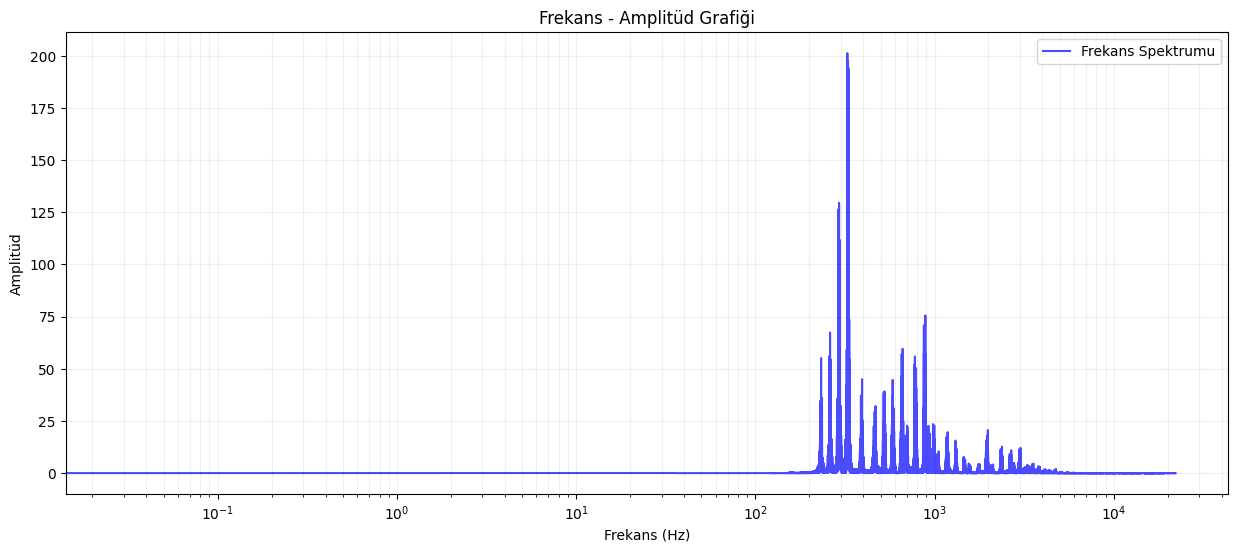

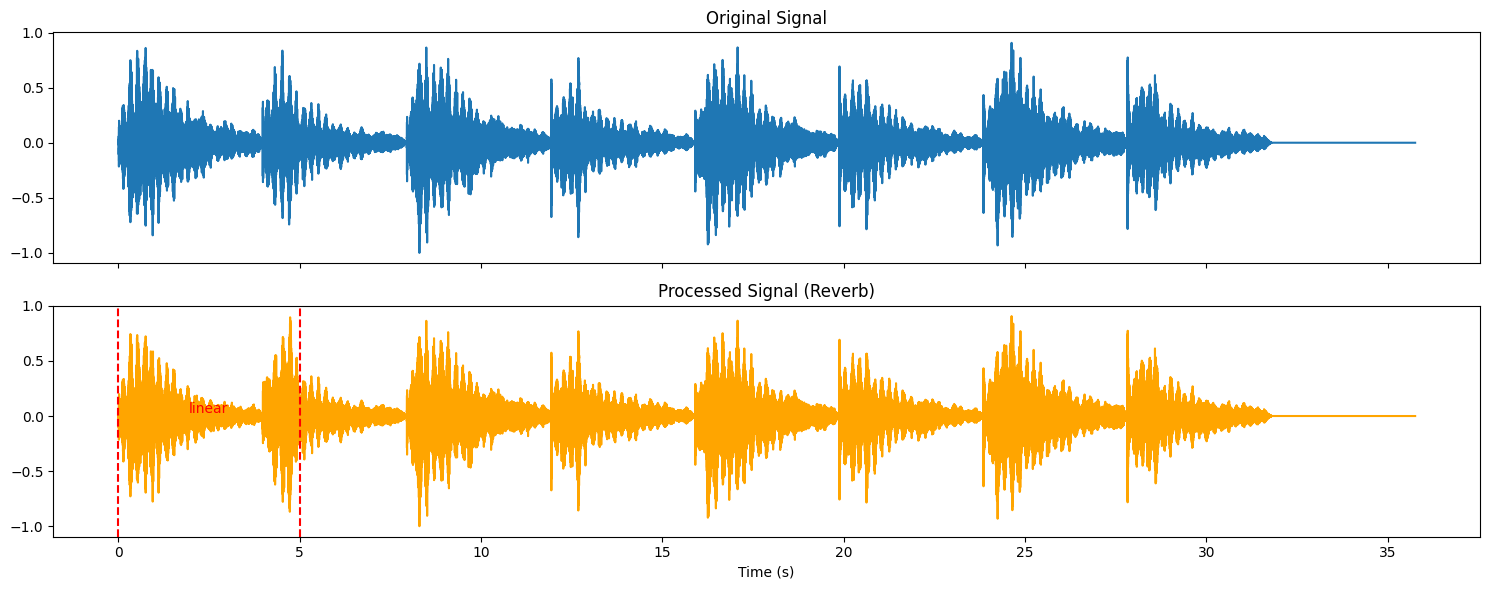

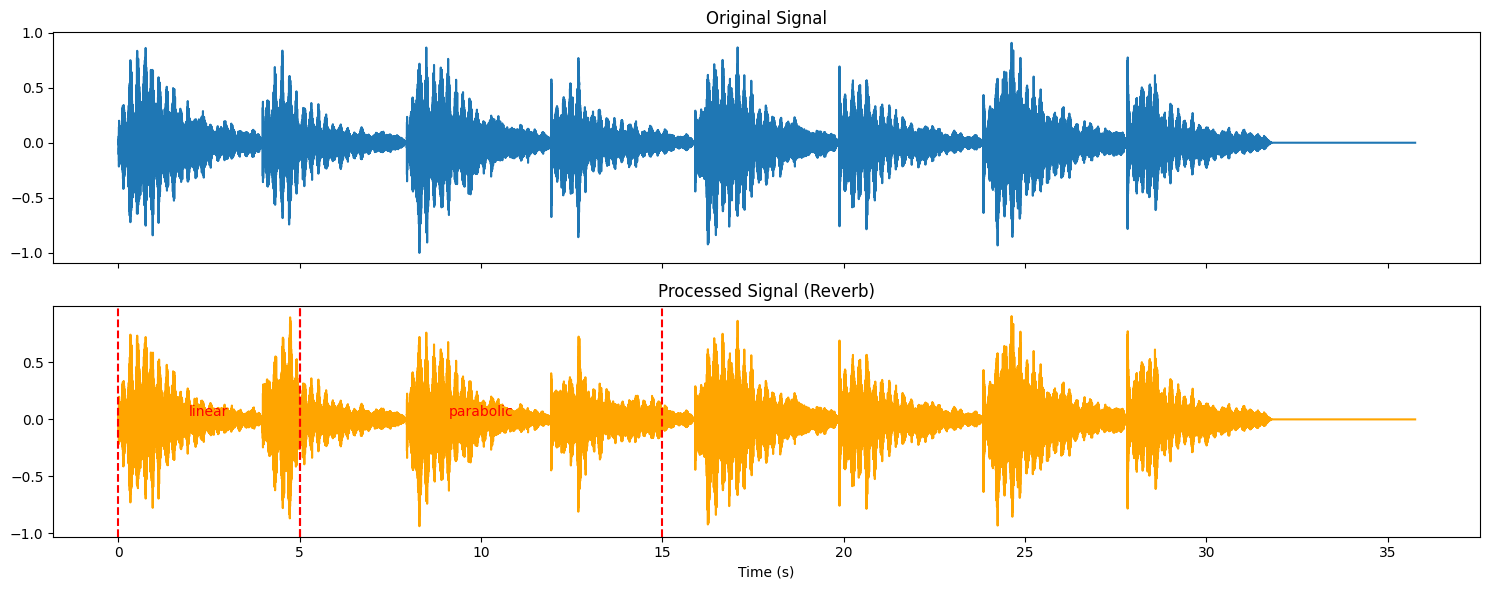

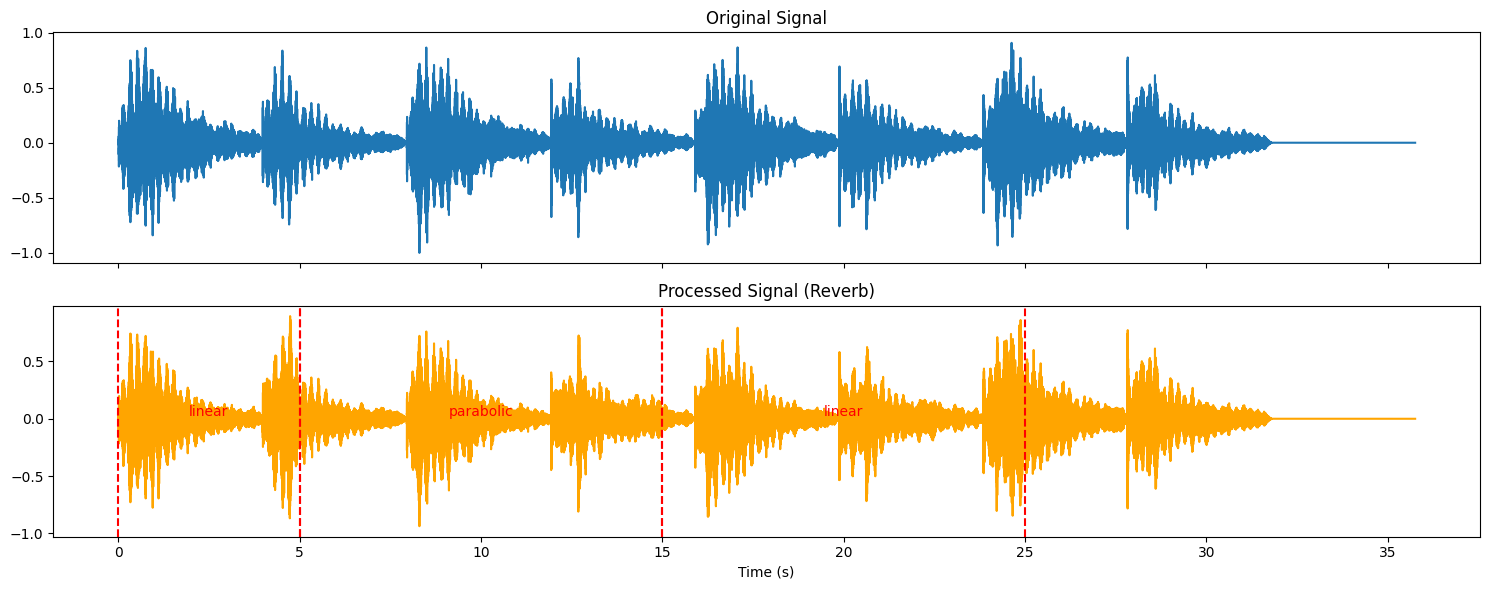

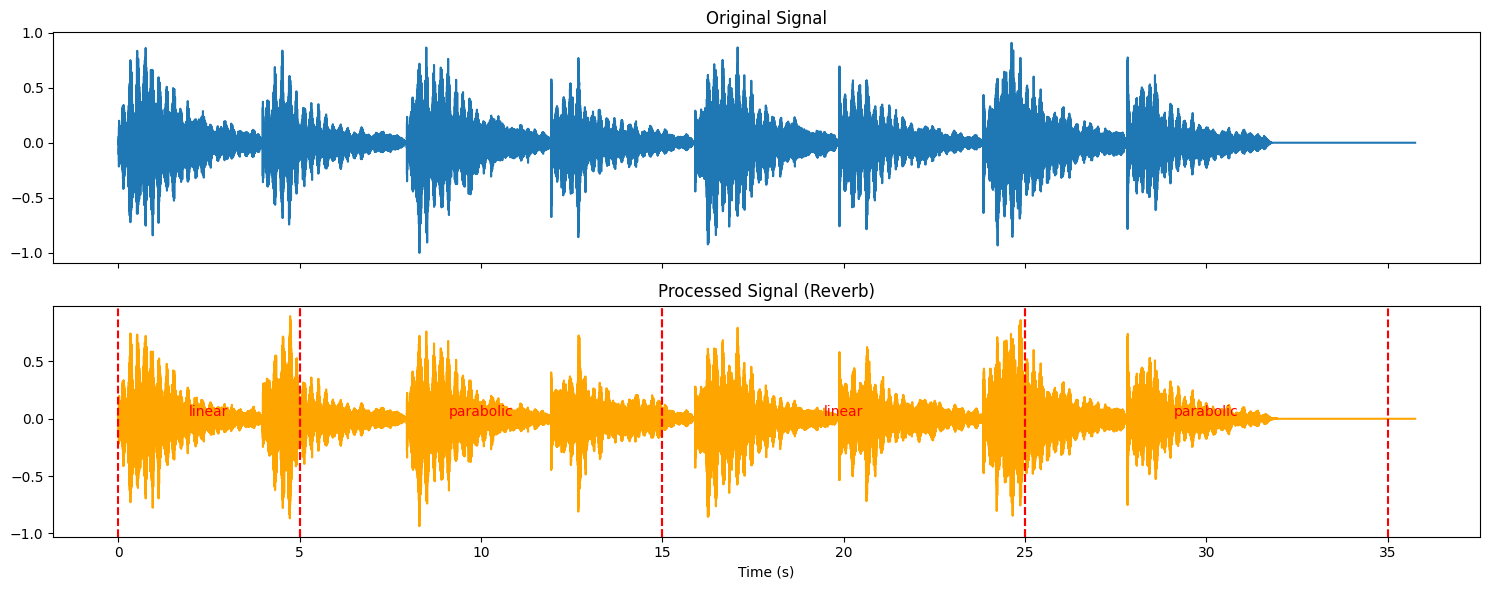

Reverb uygulanmış ses kaydedildi.
Reverb uygulanmış ses kaydedildi.
Reverb uygulanmış ses kaydedildi.
Reverb uygulanmış ses kaydedildi.
Reverb uygulanmış ses kaydedildi.
Başarıyla kaydedildi: modified_guitar (2).wav
İndirmek için:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Arayüzü göster
if 'freqs' in locals() and 'amps' in locals():
    display(ui_controls)
    plot_frequencies(freqs, modified_amps)

## Anweisungen zur Verwendung

1. laden Sie zunächst eine WAV-Datei
2. Geben Sie die zu bearbeitende Frequenz in das Textfeld "Frequenz (Hz)" ein und klicken Sie auf die Schaltfläche "Frequenz auswählen".
3. geben Sie die Einstellungen für die Amplitudenänderung und den optionalen Parabol-Effekt ein
4. drücken Sie die Schaltfläche "Änderungen übernehmen".
5. wenn Sie fertig sind, können Sie Ihre Arbeit mit der Schaltfläche "Einstellungen speichern" speichern
   oder Sie können die geänderten Audiodaten mit der Schaltfläche "Audio exportieren" als WAV-Datei herunterladen.